In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

data_path = "images/train/"

products = pd.read_csv("products.csv")

"""Some functions that help with labeling"""

# get filename function
# IMPORTANT check if the correct path is replaced
def getBarcode(dataset, number):
    barcode = dataset.imgs[number][0];
    barcode = barcode.replace('.jpg', '')
    barcode = barcode.replace('images/train/', '')
    return int(barcode)

# search_val: is the value we look for in the csv file
# csv_col: is the column in which the value should be found
# classifier: is the column's value we need in output
def getClass(search_val, csv_file, csv_col, classifier):
    for i in range(len(csv_file)):
        if csv_file[csv_col][i] == search_val:
            matching_class = csv_file[classifier][i]
            break
        else:
            matching_class = 'class not found'
    return matching_class

In [13]:
"""Loading data with PyTorch"""

# normalizing data ...
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# loading data
train_data = torchvision.datasets.ImageFolder(root=data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers = 2)

# label list
classes = np.unique(products['GS1 Form'])

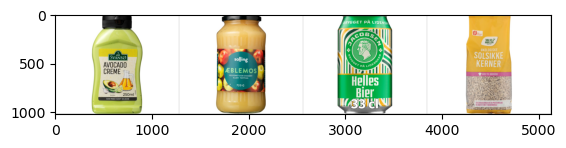

bottle jar   can   bag  


In [14]:
"""Functions to show an image"""

"""Labeling is currently unsupported"""

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
"""Convolutional Neural Network"""
"""I don't know what's happening, I just stole the code xd"""

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
"""This is our Loss function (and optimizer)"""
"""Classification Cross-Entropy loss and SGD with momentum"""

"""Lets use this for now, but later one change into our own"""

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
"""Neural network training"""

"""TODO"""

'TODO'